# Water Security

### Downloading all data

In [1]:
# Make sure you've run aws configure before hand
!aws s3 sync s3://s3groupegypt data

In [2]:
import datetime as dateformat
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import geopandas
import geoplot
import h5py
import warnings
from tqdm import tqdm
import pickle
import re
from sklearn.linear_model import LinearRegression


warnings.filterwarnings('ignore')

## Preprocessing

This section allows you to run the full pipeline from the raw data files. The full pipeline takes around 11 minutes. Alternatively, just go to the checkpoint section below and load the final master data frame.

In [3]:
# Merge 0.5x0.5 degree cells into 1x1 degree cells.
# We overlay 1x1 degree cells on the world and intersect with co-ordinates
# and aggregate using average.
# This is pretty generic and infact works with any x degree cell.
def geodataframe_overlay_grid_cells(degrees=1):
    grid = []
    for lat in np.arange(-180, 180, degrees):
        for lon in np.arange(-360, 360, degrees):
            grid.append(box(lat, lon, lat+degrees, lon+degrees))
    return grid

def geodataframe_merge_adjacent_cells(df, degrees=1, aggfunc='mean'):
    columns = df.columns[:-1]
    grid = pd.DataFrame(data={'id': np.arange(0, 360*720)})
    crs = {'init': 'epsg:4326'}
    gf = geopandas.GeoDataFrame(grid, crs=crs, geometry=geodataframe_overlay_grid_cells(degrees=degrees))
    gf_intersect = geopandas.sjoin(gf, df, how="inner", op='intersects')
    b = gf_intersect.dissolve(by='id', aggfunc = 'mean')
    return geopandas.GeoDataFrame(b[columns], geometry=b.geometry.centroid)

# Converts dataframe to geodataframe
# Dataframe must contain lon/lat fields!
def dataframe_to_geodataframe(df):
    crs = {'init': 'epsg:4326'}
    geo = [Point(row['lon'], row['lat']) for (_, row) in df[['lon', 'lat']].iterrows()]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geo)
    return gdf

frames = []

### Loading SSP2 dataset

Here we load the dataset and visualise the information with a head()/google map

In [4]:
# This dataset has population estimates every decade. We linearly impute 
# the intermediate years.
def ssp2_linear_impute(df, prefix, from_year, to_year):
    df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year) if i % 10]] = np.nan
    df_t = df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year)]].transpose()
    df_it = df_t.interpolate(method='linear', direction = 'forward').transpose()
    df_it[["lon", "lat"]] = df[["px", "py"]]
    return df_it

# Read, Impute, GeoDataFrame, Center on grid
def ssp2_load_population(from_year=1980, to_year=2017):
    population = pd.read_csv("data/SSP2/pop_ssp2.csv")
    population = ssp2_linear_impute(population, prefix="p", from_year=from_year, to_year=to_year)
    population = dataframe_to_geodataframe(population)
    population = geodataframe_merge_adjacent_cells(population)
    return population

def ssp2_load_gdp(from_year=1980, to_year=2017):
    gdp = pd.read_csv("data/SSP2/gdp_ssp2.csv")
    gdp = ssp2_linear_impute(gdp, prefix="g", from_year=from_year, to_year=to_year)
    gdp = dataframe_to_geodataframe(gdp)
    gdp = geodataframe_merge_adjacent_cells(gdp)
    return gdp

In [ ]:
population = ssp2_load_population()
gdp = ssp2_load_gdp()

frames.append(population)
frames.append(gdp)

### Loading Water GAP dataset

Here we load the dataset and visualise the information with a head()/google map

In [6]:
#Condition- function starts from year 1980, 
# nc4_file_path -> str ,nc4_key -> str, datatype either monthly or yearly
def watergap_nc4_to_dataframe(nc4_key, nc4_file, yearN=1980):
    nc4f = h5py.File(nc4_file, 'r')
    key = nc4f[nc4_key][:]
    lat = nc4f['lat'][:]
    lon = nc4f['lon'][:]
    year = yearN
    is_monthly = 'monthly' in nc4_file

    # monthly data
    if is_monthly:
        start = (yearN - 1900 - 1)*12;
        
        #Jan of YearN to Dec of 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                month = 1
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(dateformat.datetime(year, 1, month).strftime('%m/%d/%Y')))               
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                
                if i % 12 == 0:
                    year = year+1
                    month = 1
                else:
                    month = month + 1
                    
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(dateformat.datetime(year, month,1).strftime('%m/%d/%Y')))
                data_pd[str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))] = data_I.loc[:,str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))]
        
        # Convert to Yearly Data
        data_ion = data_pd['lon']
        data_no_ion = data_pd.drop(columns=['lon'])
        new = (data_no_ion.groupby(pd.PeriodIndex(data_no_ion.columns, freq='Y'), axis=1).mean().rename(columns=lambda c: str(c).lower()))
        data_pd=pd.concat([data_ion, new], axis=1) 
        
    # yearly data
    else:
        start = year - 1900 - 1;

        #YearN to 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(yearN))
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                year = year+1
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(year))
                data_pd[str(year)] = data_I.loc[:,str(year)]

    data_pd['lat'] = data_pd.index
    data_pd = data_pd.add_suffix('_%s' % nc4_key)
    data_pd.rename(columns={'lat_%s' % nc4_key : 'lat', 'lon_%s' % nc4_key : 'lon' }, inplace=True)
    return data_pd.reset_index(drop=True)

def watergap_load(key, period):
    filename = 'data/WaterGap/watergap_22d_WFDEI-GPCC_histsoc_%s_%s_1901_2016.nc4' % (key, period)
    d = watergap_nc4_to_dataframe(nc4_key=key, nc4_file=filename)
    return d


def watergap_load_all():
    watergap_vars = [("anag", "monthly"),
                 ("anas", "monthly"),
                 ("atotuse", "monthly"),
                 ("canopystor", "monthly"),
                 ("dis", "monthly"),
                 ("evap", "monthly"),
                 ("glolakestor", "monthly"),
                 ("glowetlandstor", "monthly"),
                 ("groundwstor", "monthly"),
                 ("loclakestor", "monthly"),
                 ("locwetlandstor", "monthly"),
                 ("ncrun", "monthly"),
                 ("pdomuse", "yearly"),
                 ("pdomww", "yearly"),
                 ("pgwuse", "monthly"),
                 ("pgwww", "monthly"),
                 ("pinduse", "yearly"),
                 ("pindww", "yearly"),
                 ("pirruse", "monthly"),
                 ("pirrww", "monthly"),
                 ("plivuse", "yearly"),
                 ("pnag", "monthly"),
                 ("pnas", "monthly"),
                 ("potevap", "monthly"),
                 ("precmon", "monthly"),
                 ("ptotuse", "monthly"),
                 ("ptotww", "monthly"),
                 ("qg", "monthly"),
                 ("ql", "monthly"),
                 ("qr", "monthly"),
                 ("qrdif", "monthly"),
                 ("qrswb", "monthly"),
                 ("qs", "monthly"),
                 ("reservoirstor", "monthly"),
                 ("riverstor", "monthly"),
                 ("soilmoist", "monthly"),
                 ("swe", "monthly"),
                 ("tws", "monthly"),
                 ("disnat", "monthly"),
                 ("ncrunnat", "monthly")]

    local_frames = []
    for (watergap_key, watergap_period) in tqdm(watergap_vars):
        local_frames.append(watergap_load(key=watergap_key, period=watergap_period))
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    
    d = dataframe_to_geodataframe(d)
    d = geodataframe_merge_adjacent_cells(d)
    return d

In [7]:
watergap = watergap_load_all()
watergap.head()

100%|██████████| 40/40 [06:17<00:00,  9.44s/it]


,lon,1980_anag,1981_anag,1982_anag,1983_anag,1984_anag,1985_anag,1986_anag,1987_anag,1988_anag,...,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat,geometry
id,,,,,,,,,,,,,,,,,,,,,
270,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -89.50000)
271,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -88.50000)
272,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -87.50000)
273,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -86.50000)
274,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -85.50000)


In [8]:
frames.append(watergap)

### Loading GLDAS dataset

Here we load the dataset and visualise the information with a head()/google map

In [9]:
def gldas_hdf_to_dataframe(year, month):
    year = str(year)
    hdf_file_path = 'data/gldas/GLDAS_CLSM10_M.A%s%02d.021.hdf' % (year, month)
    A = h5py.File(hdf_file_path, 'r')
    list_1 = list(A.keys())
    list_df = pd.DataFrame()
    list_df2 = pd.DataFrame()
    list_df["keys"] = list_1
    lat = A['lat']   
    lon = A['lon'] 
    data_pd = pd.DataFrame()   
    list_df2["keys"] = list_df["keys"].loc[0:37]
    count = 0
    for keys in list_df2["keys"]:
          if keys == 'ACond_tavg':
              data_arr = A[keys][0,:,:]
              data_pd = pd.DataFrame(data = data_arr)
              data_pd.columns = lon
              data_pd.index = lat
              col_n = year + "_" + keys
              data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name= col_n)
          else:
              data_arr = A[keys][0,:,:]
              data = pd.DataFrame(data = data_arr)
              data.index = lat
              col_n = year + "_" + keys
              data = pd.melt(data, ignore_index = False, value_name= col_n)
              data_pd[col_n] = data.loc[:,col_n]

    data_pd['lat'] = data_pd.index
    return data_pd.reset_index(drop=True)

def gldas_load_all():
    local_frames = []
    for year in tqdm(range(2000, 2017)):
        # We need to merge one year at a time otherwise mem swapouts hit the roof
        d = [gldas_hdf_to_dataframe(year, month) for month in range(1, 13)]
        d = pd.concat(d).groupby(['lon','lat'], group_keys=False, as_index=False).mean()
        local_frames.append(d)
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    d = dataframe_to_geodataframe(d)
    return d

In [10]:
gldas_df = gldas_load_all()

# Use that as main dataframe since GLDAS captures only a subset of the latitudes
# from 60 to -60, which are the interesting latitudes anyways. 
frames.insert(0, gldas_df)

100%|██████████| 17/17 [00:53<00:00,  3.13s/it]


In [11]:
gldas_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2016_SoilTMP144_295cm_inst,2016_SoilTMP295_1295cm_inst,2016_SoilTMP29_68cm_inst,2016_SoilTMP68_144cm_inst,2016_Swnet_tavg,2016_TVeg_tavg,2016_TWS_inst,2016_Tair_f_inst,2016_Wind_f_inst,geometry
0,-179.5,-59.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -59.50000)
1,-179.5,-58.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -58.50000)
2,-179.5,-57.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -57.50000)
3,-179.5,-56.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -56.50000)
4,-179.5,-55.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -55.50000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,179.5,85.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 85.50000)
53996,179.5,86.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 86.50000)
53997,179.5,87.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 87.50000)
53998,179.5,88.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 88.50000)


### Merging the dataframe

Here we load the dataset and visualise the information with a head()/google map

In [19]:
def geodataframe_spatial_merge(frames):
    main_frame = frames[0]
    for frame in frames[1:]:
        main_frame = main_frame.merge(frame)
    return main_frame

In [20]:
master_df = geodataframe_spatial_merge(frames)
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2007_ncrunnat,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000014,0.000015,0.000024,0.000019,0.000029,0.000019,0.000016,0.000025,0.000026,0.000019
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000012,0.000012,0.000020,0.000015,0.000024,0.000017,0.000013,0.000022,0.000022,0.000018
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000011,0.000007,0.000019,0.000014,0.000023,0.000012,0.000011,0.000018,0.000018,0.000017
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000006,0.000006,0.000011,0.000008,0.000013,0.000010,0.000007,0.000013,0.000013,0.000010
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000010,0.000006,0.000016,0.000012,0.000019,0.000011,0.000009,0.000016,0.000016,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000013,0.000010,0.000021,0.000017,0.000026,0.000014,0.000014,0.000019,0.000019,0.000015
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000011,0.000014,0.000019,0.000016,0.000023,0.000016,0.000014,0.000020,0.000020,0.000011
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000008,0.000012,0.000009,0.000010,0.000012,0.000013,0.000009,0.000011,0.000011,0.000008
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000012,0.000010,0.000020,0.000017,0.000027,0.000014,0.000013,0.000019,0.000019,0.000015


# Checkpoint (save/load)

In [5]:

def save_checkpoint(df):
    with open('data/master_df.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_checkpoint():
    with open('data/master_df.pickle', 'rb') as handle:
        return pickle.load(handle)

# Do not uncomment this unless you want to save a new version of the master dataframe
# save_checkpoint(master_df)

master_df = load_checkpoint()

In [6]:
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2007_ncrunnat,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000014,0.000015,0.000024,0.000019,0.000029,0.000019,0.000016,0.000025,0.000026,0.000019
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000012,0.000012,0.000020,0.000015,0.000024,0.000017,0.000013,0.000022,0.000022,0.000018
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000011,0.000007,0.000019,0.000014,0.000023,0.000012,0.000011,0.000018,0.000018,0.000017
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000006,0.000006,0.000011,0.000008,0.000013,0.000010,0.000007,0.000013,0.000013,0.000010
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000010,0.000006,0.000016,0.000012,0.000019,0.000011,0.000009,0.000016,0.000016,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000013,0.000010,0.000021,0.000017,0.000026,0.000014,0.000014,0.000019,0.000019,0.000015
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000011,0.000014,0.000019,0.000016,0.000023,0.000016,0.000014,0.000020,0.000020,0.000011
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000008,0.000012,0.000009,0.000010,0.000012,0.000013,0.000009,0.000011,0.000011,0.000008
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000012,0.000010,0.000020,0.000017,0.000027,0.000014,0.000013,0.000019,0.000019,0.000015


# Projecting into the future

In this section we attempt to understand how best to model the different variables in order to predict future values.

In [7]:
acond_tavg = master_df.filter(regex=(".*_ACond_tavg"))

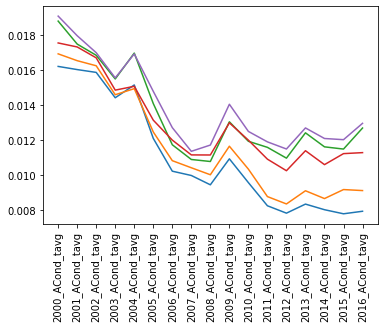

In [8]:
plt.xticks(rotation=90)
for i in range(5):
    plt.plot(acond_tavg.iloc[i])

In [9]:

def glm_fit_per_cell(varname):
    v = master_df.filter(regex=(".*_%s$" % varname))
    years = [int(re.search("(.*)_%s" % varname, s).group(1)) for s in v.columns]
    min_year = min(years)
    max_year = max(years)
    x = np.arange(min_year, max_year + 1).reshape((-1, 1))
    rsqrd = []
    models = []
    for y in v.iloc:
        model = LinearRegression().fit(x, y)
        models.append(model)
        rsqrd.append(model.score(x, y))
    return (models, rsqrd)
    
acond_models, acond_rsqrd = glm_fit_per_cell("ACond_tavg")

(array([2497., 1054.,  915.,  824.,  884.,  937., 1127., 1233., 1172.,
         237.]),
 array([1.39917108e-08, 1.00000013e-01, 2.00000011e-01, 3.00000010e-01,
        4.00000008e-01, 5.00000007e-01, 6.00000006e-01, 7.00000004e-01,
        8.00000003e-01, 9.00000001e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

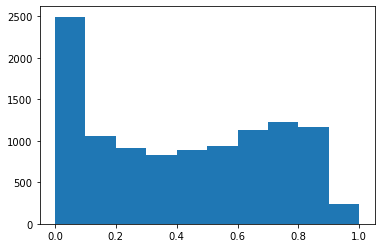

In [10]:
plt.hist(acond_rsqrd)

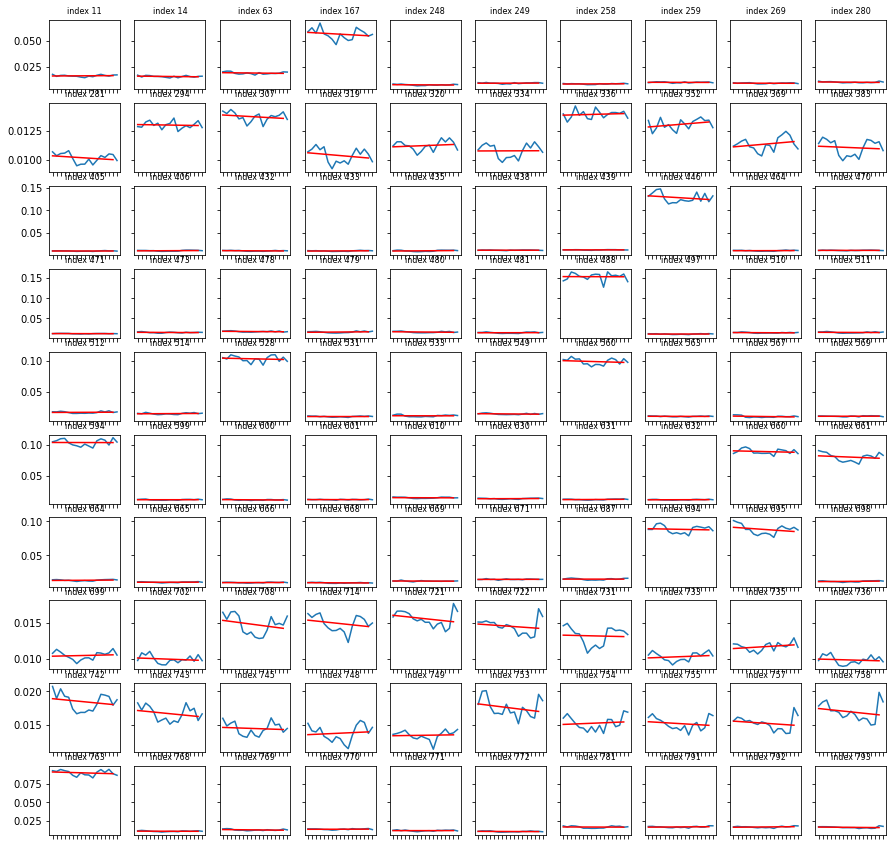

In [13]:
low_scorers = np.where(np.array(acond_rsqrd) < 0.1)[0]
fig, ax = plt.subplots(10, 10, sharex='col', sharey='row', figsize=(15,15))
i = 0
for row in ax:
    for gridplt in row:
        real_idx = low_scorers[i]
        gridplt.set_xticklabels([])
        gridplt.title.set_text('index %d' % real_idx)
        gridplt.title.set_size(8)
        x = np.arange(2000, 2016).reshape((-1, 1))
        y = acond_tavg.iloc[real_idx]
        gridplt.plot(y)
        gridplt.plot([acond_models[real_idx].intercept_ + acond_models[real_idx].coef_[0] * xv for xv in x], 'r')
        i += 1

It is not ideal, but the lines capture the general trend of the variable in each geographical cell.

In [17]:
def project_all_models(df):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    all_var_models = []
    for v in tqdm(all_vars):
        v_models, _ = glm_fit_per_cell(v)
        all_var_models.append(v_models)
    return all_var_models

def project_cell(df, idx, year, all_models):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    return [all_models[i][idx].coef_[0] * year + all_models[i][idx].intercept_ for i, v in enumerate(all_vars)]

def project_ssp2_data(df, year):
    # Load GDP/population projections from SSP2
    ssp2_copy = df.copy()
    pop = ssp2_load_population(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(pop)
    gdp = ssp2_load_gdp(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(gdp)
    return ssp2_copy
    
def project_df(df, year, all_models):
    future_df_spec = {'lon': df['lon'], 'lat': df['lat']}
    future_array = np.array([project_cell(df, i, year, all_models) for i in range(len(df))])
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    for i, var in enumerate(all_vars):
        future_df_spec.update({'%s_%s' % (year, var): future_array[:,i]})
    ssp2_copy = project_ssp2_data(df, year)
    pop_year = 'p2_%s' % year
    gdp_year = 'g2_%s' % year
    future_df_spec.update({gdp_year: ssp2_copy[gdp_year]})
    future_df_spec.update({pop_year: ssp2_copy[pop_year]})
    future_df = dataframe_to_geodataframe(pd.DataFrame(future_df_spec))
    new_df = df.copy()
    return new_df.merge(future_df)

In [18]:
all_var_models = project_all_models(master_df)
future_df = project_df(master_df, 2050, all_var_models)
future_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06


In [19]:
future_df

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-0.013869,-925.042221,250.929574,0.029180,3.752627,24.536195,0.000012,189.540770,-44.851951,94761.175551,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-0.011389,72.577574,254.058168,0.022557,4.405940,25.275895,0.000013,198.141227,-47.528701,101079.139476,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-0.003665,33.197989,258.834864,0.016525,3.227895,26.701101,0.000013,202.450659,-56.975382,97894.578929,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-0.004645,-1109.564013,257.299404,0.016314,3.921367,25.212307,0.000013,201.360342,-54.558425,101690.394761,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-0.002767,32.830386,259.587475,0.023407,3.655577,25.551612,0.000013,203.671407,-58.685369,100679.494830,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,-0.004671,32.436099,258.269015,0.023779,4.567940,32.097315,0.000017,203.560904,-55.888015,99990.368107,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,-0.014454,-226.978261,255.300737,0.021937,3.521912,32.012160,0.000015,194.714345,-55.325165,96549.072381,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,-0.010815,-803.639743,253.347366,0.032414,4.313263,28.691743,0.000015,191.443827,-53.178857,99531.502872,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,-0.007007,30.679041,261.504620,0.026342,3.783810,33.666969,0.000016,215.281378,-55.785559,106552.358571,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06
